In [ ]:
# ============================================================
# CONFIGURACIÓN E IMPORTS
# ============================================================

from pathlib import Path
import sys
import pandas as pd

# Agregar la raíz del proyecto al path
ROOT = Path().resolve().parent
sys.path.insert(0, str(ROOT))

# Importar configuración centralizada
from config import PATHS, CONFIG

print("✓ Configuración cargada correctamente")

# ========================================
# RUTAS USANDO PATHS
# ========================================

CARPETA_FEATURES = PATHS.FEATURES
CARPETA_FINAL = PATHS.FEATURES_FINAL
CARPETA_RESULTS = PATHS.RESULTS

# Crear carpeta de resultados si no existe
CARPETA_RESULTS.mkdir(parents=True, exist_ok=True)

# Archivos de datos usando PATHS
ARCHIVO_CARACTERISTICAS = PATHS.CARACTERISTICAS_COMPLETAS
ARCHIVO_PSICOMETRICO = PATHS.DATOS_PSICOMETRICOS

print(f"\nArchivos a utilizar:")
print(f"  - Características: {ARCHIVO_CARACTERISTICAS}")
print(f"  - Psicométricos: {ARCHIVO_PSICOMETRICO}")
print(f"  - Resultados: {CARPETA_RESULTS}")

In [ ]:
# ========================================
# CARGAR Y CONSOLIDAR DATOS
# ========================================

# Verificar que los archivos existen
if not ARCHIVO_CARACTERISTICAS.exists():
    print(f" Error: No se encuentra {ARCHIVO_CARACTERISTICAS}")
    print(f"   Ejecuta primero el notebook de características")
elif not ARCHIVO_PSICOMETRICO.exists():
    print(f" Error: No se encuentra {ARCHIVO_PSICOMETRICO}")
    print(f"   Ejecuta primero el notebook 5-Psicoanalisis.ipynb")
else:
    # Cargar archivos,
    print("\n Cargando datos...")
    df_caracteristicas_raw = pd.read_csv(ARCHIVO_CARACTERISTICAS, encoding='utf-8-sig')
    df_psicometricos = pd.read_csv(ARCHIVO_PSICOMETRICO, encoding='utf-8-sig')
    
    print(f"✓ Características (raw): {len(df_caracteristicas_raw)} publicaciones")
    print(f"✓ Psicométricos: {len(df_psicometricos)} participantes")
    
    # Agregar características por participante
    print("\n Agregando características por participante...")
    
    # Calcular métricas agregadas
    df_caracteristicas = df_caracteristicas_raw.groupby('id_participante').agg({
        # Conteo de publicaciones
        'id_publicacion': 'count',
        
        # Promedios de características textuales
        'num_palabras': 'mean',
        'num_caracteres': 'mean',
        'longitud_palabra_prom': 'mean',
        'palabras_unicas': 'mean',
        'riqueza_lexica': 'mean',
        
        # Promedios de puntuación
        'num_signos_exclamacion': 'mean',
        'num_signos_pregunta': 'mean',
        
        # Promedios de pronombres
        'pct_pronombres_1era_sing': 'mean',
        'pct_pronombres_1era_plur': 'mean',
        'pct_pronombres_2da': 'mean',
        'pct_pronombres_3era': 'mean',
        
        # Promedios de palabras psicológicas
        'pct_absolutistas': 'mean',
        'pct_negativas': 'mean',
        'pct_causales': 'mean',
        'pct_tentativas': 'mean',
        
        # Emojis
        'num_emojis': 'sum',
        'emojis_por_palabra': 'mean',
        
        # Sentimiento
        'score_pos': 'mean',
        'score_neg': 'mean',
        'score_neu': 'mean',
        
        # Emociones
        'score_alegria': 'mean',
        'score_tristeza': 'mean',
        'score_enojo': 'mean',
        'score_miedo': 'mean',
        'score_sorpresa': 'mean',
        'score_disgusto': 'mean',
    }).reset_index()
    
    # Renombrar columnas para mayor claridad
    df_caracteristicas.rename(columns={
        'id_publicacion': 'num_publicaciones',
        'num_palabras': 'promedio_palabras',
        'num_caracteres': 'promedio_caracteres',
        'longitud_palabra_prom': 'promedio_longitud_palabra',
        'palabras_unicas': 'promedio_palabras_unicas',
        'riqueza_lexica': 'promedio_riqueza_lexica',
        'num_signos_exclamacion': 'promedio_exclamaciones',
        'num_signos_pregunta': 'promedio_preguntas',
        'pct_pronombres_1era_sing': 'promedio_pronombres_1era_sing',
        'pct_pronombres_1era_plur': 'promedio_pronombres_1era_plur',
        'pct_pronombres_2da': 'promedio_pronombres_2da',
        'pct_pronombres_3era': 'promedio_pronombres_3era',
        'pct_absolutistas': 'promedio_absolutistas',
        'pct_negativas': 'promedio_negativas',
        'pct_causales': 'promedio_causales',
        'pct_tentativas': 'promedio_tentativas',
        'num_emojis': 'total_emojis',
        'emojis_por_palabra': 'promedio_emojis_por_palabra',
        'score_pos': 'promedio_score_positivo',
        'score_neg': 'promedio_score_negativo',
        'score_neu': 'promedio_score_neutral',
        'score_alegria': 'promedio_alegria',
        'score_tristeza': 'promedio_tristeza',
        'score_enojo': 'promedio_enojo',
        'score_miedo': 'promedio_miedo',
        'score_sorpresa': 'promedio_sorpresa',
        'score_disgusto': 'promedio_disgusto',
    }, inplace=True)
    
    # Calcular métricas adicionales
    df_caracteristicas['ratio_pos_neg'] = df_caracteristicas['promedio_score_positivo'] / (df_caracteristicas['promedio_score_negativo'] + 0.001)
    
    # Porcentaje de publicaciones con sentimiento predominante
    sent_counts = df_caracteristicas_raw.groupby(['id_participante', 'sentimiento']).size().unstack(fill_value=0)
    if 'positive' in sent_counts.columns:
        df_caracteristicas['pct_publicaciones_positivas'] = (sent_counts['positive'] / sent_counts.sum(axis=1) * 100).values
    if 'negative' in sent_counts.columns:
        df_caracteristicas['pct_publicaciones_negativas'] = (sent_counts['negative'] / sent_counts.sum(axis=1) * 100).values
    if 'neutral' in sent_counts.columns:
        df_caracteristicas['pct_publicaciones_neutrales'] = (sent_counts['neutral'] / sent_counts.sum(axis=1) * 100).values
    
    print(f"✓ Características agregadas: {len(df_caracteristicas)} participantes, {len(df_caracteristicas.columns)} columnas")
    
    # Consolidar datasets (inner join para tener solo participantes con ambos datos)
    df_completo = df_caracteristicas.merge(
        df_psicometricos,
        on='id_participante',
        how='inner'
    )
    
    print(f"\n Dataset consolidado: {len(df_completo)} participantes, {len(df_completo.columns)} columnas")
    
    # Guardar dataset consolidado
    from datetime import datetime
    fecha_actual = datetime.now().strftime("%Y%m%d")
    archivo_salida = CARPETA_FINAL / f"dataset_consolidado.csv"
    
    # Antes de guardar, comprobar si ya existe un consolidado previo (por ejemplo, con métricas temporales)
    try:
        from pathlib import Path
        if archivo_salida.exists():
            df_prev = pd.read_csv(archivo_salida, encoding='utf-8-sig')
            # Detectar columnas adicionales (posibles métricas temporales) presentes en el consolidado previo
            cols_extra = [c for c in df_prev.columns if c not in df_completo.columns and c != 'id_participante']
            if cols_extra:
                print(f"\n⚠️  Se detectaron columnas extra en el consolidado previo: {cols_extra}")
                # Incorporarlas al nuevo consolidado si no existen
                df_extra = df_prev[['id_participante'] + cols_extra]
                df_completo = df_completo.merge(df_extra, on='id_participante', how='left')
                print(f"✓ Columnas extra integradas al nuevo consolidado: {len(cols_extra)}")
        # Guardar consolidado (ahora con posibles columnas temporales preservadas)
        df_completo.to_csv(archivo_salida, index=False, encoding='utf-8-sig')
        print(f"\n💾 Dataset consolidado guardado en: {archivo_salida}")
    except Exception as e:
        # Fallback: guardar normalmente y mostrar aviso
        print(f"\n⚠️  Error preservando columnas previas: {e}")
        df_completo.to_csv(archivo_salida, index=False, encoding='utf-8-sig')
        print(f"\n💾 Dataset consolidado guardado en: {archivo_salida} (sin preservación de extras)")
    
    print(f"\nColumnas del dataset:")
    for col in sorted(df_completo.columns):
        print(f"   - {col}")

✓ DataFrame cargado: 18 participantes
✓ Columnas disponibles: 60

 Indicadores digitales disponibles: 14
   - promedio_score_positivo
   - promedio_score_negativo
   - promedio_score_neutral
   - ratio_pos_neg
   - num_publicaciones
   - promedio_palabras
   - promedio_absolutistas
   - promedio_negativas
   - promedio_alegria
   - promedio_tristeza
   - promedio_enojo
   - promedio_miedo
   - total_emojis
   - promedio_emojis_por_palabra

 Medidas psicométricas disponibles: 4
   - ucla_total
   - dass_depresion
   - dass_ansiedad
   - dass_estres

CALCULANDO CORRELACIONES...

MATRIZ DE CORRELACIONES (Spearman)
                            ucla_total dass_depresion dass_ansiedad  \
promedio_score_positivo          0.295          0.316         0.420   
promedio_score_negativo         -0.098         -0.093        -0.070   
promedio_score_neutral           0.032         -0.024         0.009   
ratio_pos_neg                    0.166          0.161         0.176   
num_publicaciones         

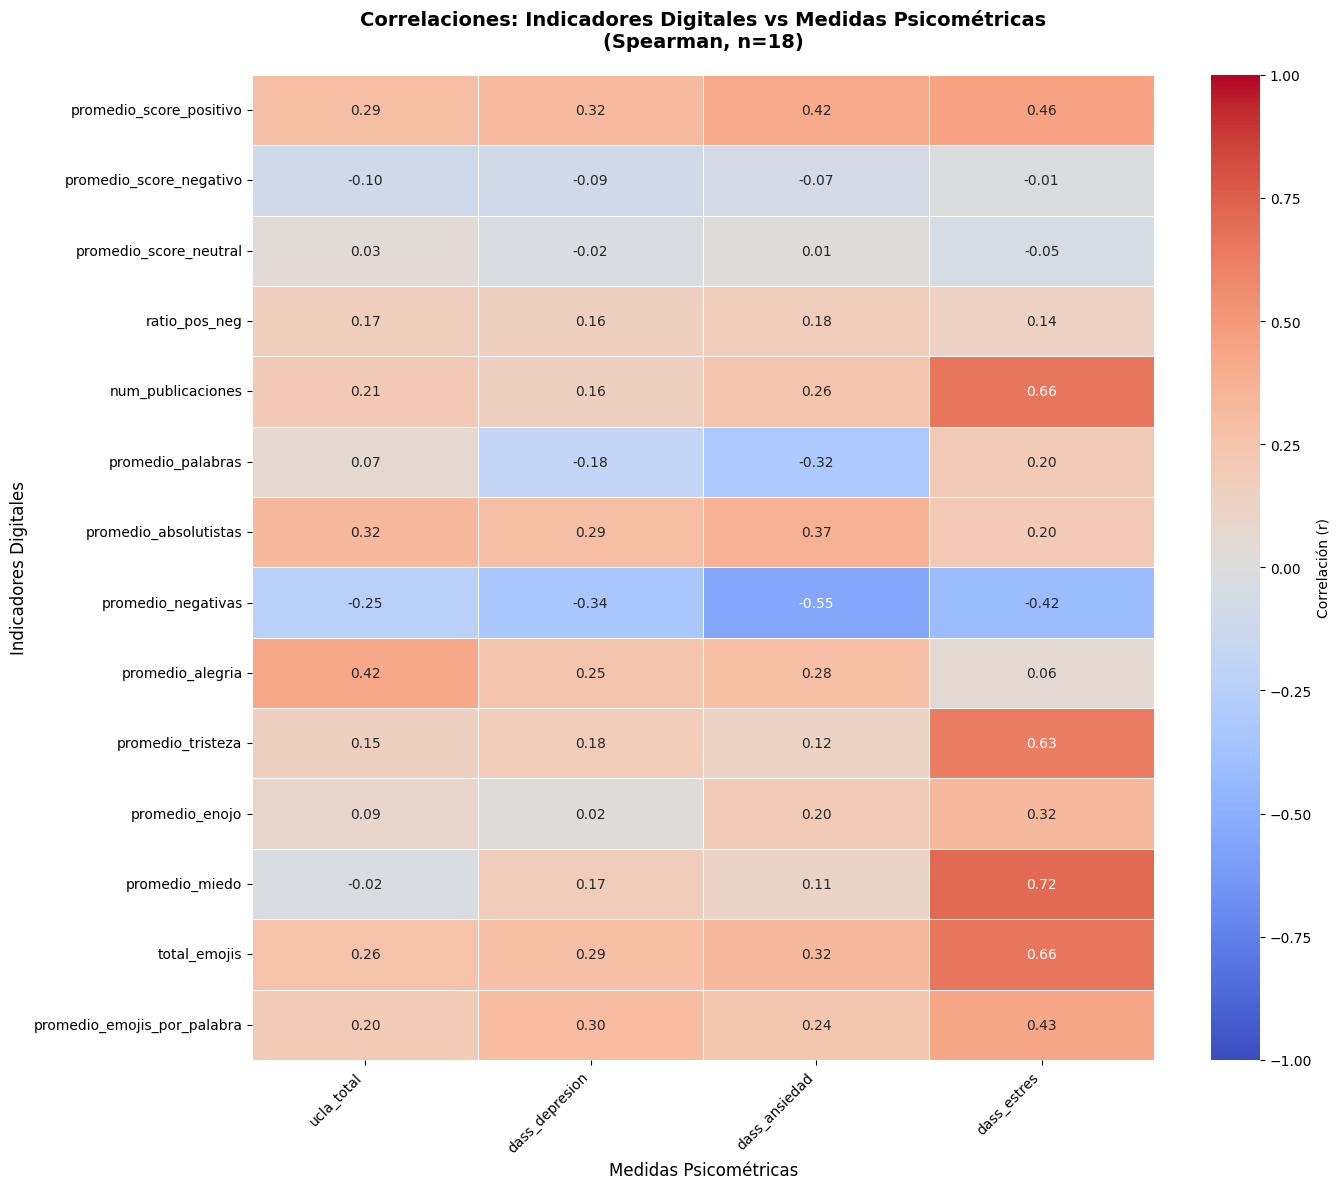


✅ Heatmap guardado: /Users/miguelzelaya/Documents/GitHub/Indicadores_Comportamiento/data/results/heatmap_correlaciones.pdf


In [3]:
import numpy as np
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataset consolidado (sin dtype=str para mantener tipos numéricos)
df_completo = pd.read_csv(archivo_salida, encoding='utf-8-sig')

# ========================================
# 7. ANÁLISIS DE CORRELACIONES
# ========================================

# Verificar que df_completo existe
if 'df_completo' not in globals():
    print(" Error: df_completo no está definido")
    print("   Ejecuta las celdas anteriores para cargar los datos")
else:
    print(f"✓ DataFrame cargado: {len(df_completo)} participantes")
    print(f"✓ Columnas disponibles: {len(df_completo.columns)}")
    
    # Definir indicadores candidatos (verificaremos cuáles existen)
    indicadores_digitales_candidatos = [
        'promedio_score_positivo',
        'promedio_score_negativo',
        'promedio_score_neutral',
        'ratio_pos_neg',
        'pct_publicaciones_negativas',
        'pct_publicaciones_positivas',
        'num_publicaciones',
        'promedio_palabras',
        'promedio_absolutistas',
        'promedio_negativas',
        'promedio_alegria',
        'promedio_tristeza',
        'promedio_enojo',
        'promedio_miedo',
        'total_emojis',
        'promedio_emojis_por_palabra',
    ]
    
    # Medidas psicométricas
    medidas_psicometricas_candidatas = [
        'ucla_total',
        'dass_depresion',
        'dass_ansiedad',
        'dass_estres'
    ]
    
    # Filtrar solo las columnas que existen en el DataFrame
    indicadores_digitales = [col for col in indicadores_digitales_candidatos if col in df_completo.columns]
    medidas_psicometricas = [col for col in medidas_psicometricas_candidatas if col in df_completo.columns]
    
    print(f"\n Indicadores digitales disponibles: {len(indicadores_digitales)}")
    for ind in indicadores_digitales:
        print(f"   - {ind}")
    
    print(f"\n Medidas psicométricas disponibles: {len(medidas_psicometricas)}")
    for psico in medidas_psicometricas:
        print(f"   - {psico}")
    
    if not indicadores_digitales or not medidas_psicometricas:
        print("\n Error: No hay suficientes variables para calcular correlaciones")
        print("   Verifica que los datos se hayan procesado correctamente")
    elif len(df_completo) < 3:
        print(f"\n Error: Solo tienes {len(df_completo)} participante(s)")
        print("   Se necesitan al menos 3 participantes para calcular correlaciones válidas")
    else:
        # Crear matriz de correlaciones
        matriz_correlaciones = pd.DataFrame(
            index=indicadores_digitales,
            columns=medidas_psicometricas
        )
        
        matriz_pvalues = pd.DataFrame(
            index=indicadores_digitales,
            columns=medidas_psicometricas
        )
        
        # Calcular correlaciones (Spearman para datos no paramétricos)
        print(f"\n{'='*80}")
        print("CALCULANDO CORRELACIONES...")
        print(f"{'='*80}")
        
        for ind in indicadores_digitales:
            for psico in medidas_psicometricas:
                # Filtrar valores válidos
                valid_data = df_completo[[ind, psico]].dropna()
                
                if len(valid_data) >= 3:  # Mínimo 3 observaciones
                    corr, pval = spearmanr(valid_data[ind], valid_data[psico])
                    
                    # Formatear con significancia
                    if pval < 0.01:
                        matriz_correlaciones.loc[ind, psico] = f"{corr:.3f}**"
                    elif pval < 0.05:
                        matriz_correlaciones.loc[ind, psico] = f"{corr:.3f}*"
                    else:
                        matriz_correlaciones.loc[ind, psico] = f"{corr:.3f}"
                    
                    matriz_pvalues.loc[ind, psico] = pval
                else:
                    matriz_correlaciones.loc[ind, psico] = 'N/A'
                    matriz_pvalues.loc[ind, psico] = 1.0
        
        print("\n" + "="*80)
        print("MATRIZ DE CORRELACIONES (Spearman)")
        print("="*80)
        print(matriz_correlaciones)
        print("\n*p < 0.05, **p < 0.01")
        
        # Guardar tabla en carpeta de resultados
        archivo_tabla = CARPETA_RESULTS / 'tabla_correlaciones.csv'
        matriz_correlaciones.to_csv(archivo_tabla)
        print(f"\n✓ Tabla guardada: {archivo_tabla}")
        
        # ========================================
        # 8. VISUALIZACIÓN: HEATMAP DE CORRELACIONES
        # ========================================
        
        print(f"\n{'='*80}")
        print("GENERANDO HEATMAP...")
        print(f"{'='*80}")
        
        # Convertir a valores numéricos para visualizar
        matriz_numerica = matriz_correlaciones.copy()
        for col in matriz_numerica.columns:
            matriz_numerica[col] = pd.to_numeric(
                matriz_numerica[col].str.replace('*', '', regex=False).str.replace('N/A', 'nan'),
                errors='coerce'
            )
        
        # Verificar si hay valores válidos
        if matriz_numerica.notna().sum().sum() == 0:
            print(" No hay correlaciones válidas para graficar")
        else:
            plt.figure(figsize=(14, 12))
            sns.heatmap(
                matriz_numerica.astype(float),
                annot=True,
                fmt='.2f',
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1,
                cbar_kws={'label': 'Correlación (r)'},
                linewidths=0.5,
                square=False
            )
            plt.title(f'Correlaciones: Indicadores Digitales vs Medidas Psicométricas\n(Spearman, n={len(df_completo)})', 
                      fontsize=14, fontweight='bold', pad=20)
            plt.xlabel('Medidas Psicométricas', fontsize=12)
            plt.ylabel('Indicadores Digitales', fontsize=12)
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)
            plt.tight_layout()
            
            # Guardar heatmap en carpeta de resultados
            archivo_heatmap = CARPETA_RESULTS / 'heatmap_correlaciones.pdf'
            plt.savefig(archivo_heatmap, dpi=300, bbox_inches='tight')
            plt.show()
            
            print(f"\n✅ Heatmap guardado: {archivo_heatmap}")